In [9]:
from database import CPHS2017Database
from zoneinfo import ZoneInfo
from util import PATTERN, SIGNAL_TYPE_STR_MAP, ORDER_STRING_TO_NUM, AssayType, assay_index_to_type
from glob import glob
from datetime import datetime, timezone
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import textwrap
from copy import deepcopy

from scipy.stats import circmean

import numpy as np

from typing import Literal

from math import tau

import re

NUM_VARIABLES = 6
NUM_FFT_VARIABLES = 3
NUM_PARTICIPANTS = 7
NUM_ORDERS = 2
NUM_SAMPLES = 2400
NUM_SAMPLES_FFT = 1201
NUM_SAMPLES_RAW = 2702

SAMPLING_FREQUENCY = 60
NYQUIST_FREQUENCY = 0.5 * SAMPLING_FREQUENCY
SAMPLING_PERIOD = 1 / SAMPLING_FREQUENCY

def get_trial_data(db: CPHS2017Database, order, participant_num, parity: Literal['even', 'odd'],):
    """Helper function to retrieve and organize trial data for a participant."""

    even_ref_query = (
        f"(assay_type == {AssayType.SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD}) | " 
        f"(assay_type == {AssayType.SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD})"
    )
    
    odd_ref_query = (
        f"(assay_type == {AssayType.SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN}) | "
        f"(assay_type == {AssayType.SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN})"
    )

    assay_query = even_ref_query if parity == 'even' else odd_ref_query

    query_expr = f"(order == {order}) & ({assay_query}) & (participant_num == {participant_num})"
    where_list = db.get_where_list(query_expr)
    
    Hur_data = db.tf_reference_to_input[:][where_list]
    Hud_data = db.tf_disturbance_to_input[:][where_list]
    
    return Hur_data[:, :NUM_SAMPLES_FFT], Hud_data[:, :NUM_SAMPLES_FFT]

In [10]:
# Some jank to precisely calculate these.

vfs = ['fo', 'so']
num_refs = 5
#vf = vfs[order - 1]

np.random.seed(49)
period = 20 # sec
f_base = 1./period # Hz
# TODO go up to 3--5Hz -- check that Sam can track, and check when becomes sub-pixel
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199])
f_max = dict(fo=2,so=1)
p_max = dict([(vf,np.nonzero(primes*f_base <= f_max[vf])[0][-1]) for vf in vfs])

phase_shifts_r = dict([(vf,np.random.rand(num_refs,p_max[vf])) for vf in vfs])

# only first disturbance signal differs from reference signals
phase_shifts_d = deepcopy(phase_shifts_r)
for vf in vfs:
    phase_shifts_d[vf][0] = np.random.rand(p_max[vf])

def get_phase_shifts(vf=None, shift_id=None, signal_type: Literal['reference', 'disturbance']='reference'):
    """
    Returns phase shifts for the given vector field and index.
    
    Args:
        vf (str, optional): Vector field ('fo' or 'so'). If None, returns all.
        shift_id (int, optional): Index of the trial (0 to num_refs-1). If None, returns all.
        signal_type (str): 'reference' or 'disturbance'.
    
    Returns:
        dict or np.ndarray: Phase shifts for the specified parameters.
    """

    if signal_type == 'reference':
        phase_shifts = phase_shifts_r
    elif signal_type == 'disturbance':
        phase_shifts = phase_shifts_d
    else:
        raise ValueError("signal_type must be 'reference' or 'disturbance'")
    
    if vf is None:
        # Return all phase shifts for all vector fields
        return phase_shifts
    elif vf in phase_shifts:
        if shift_id is None:
            # Return all phase shifts for the specified vector field
            return phase_shifts[vf]
        else:
            # Return phase shifts for the specified vector field and shift_id
            return phase_shifts[vf][shift_id]
    else:
        raise ValueError(f"Vector field '{vf}' not found. Available options: {list(phase_shifts.keys())}")


Found database cphs2017.h5
Logs table found in database cphs2017.h5.
0.0015535195668538414


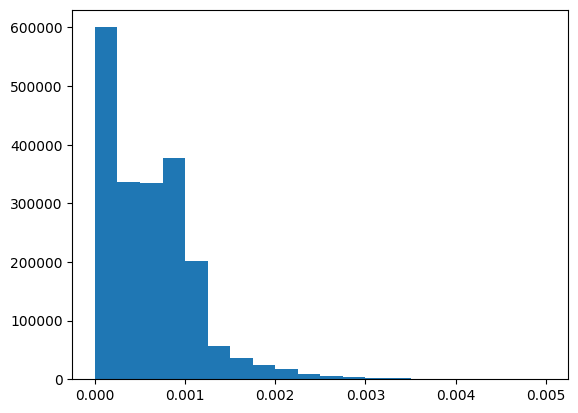

In [63]:
import matplotlib.pyplot as plt


with CPHS2017Database() as db:
    dt = np.abs(np.diff(db.real_time[:], axis=1) - 1 / 60).flatten()
    print(np.quantile(dt, .95))
    plt.hist(dt, bins=20, range=[0, 0.005])

In [11]:
import xarray as xr


dt = xr.DataTree(
    xr.Dataset(
        coords = {
            'participant': ["dp", "ef", "gy", "iz", "ly", "wv", "zu"],
            'condition': [
                'R_ONLY',
                'D_ONLY',
                'R+EVEN_D+ODD',
                'R+ODD_D+EVEN',
                'R-EVEN_D+ODD',
                'R-ODD_D+EVEN',
            ],
            'trial': np.arange(10),
            'sample': np.arange(2702),
            'fft_sample': np.arange(1201),
            'order': np.arange(1, 3),
            'state_var': np.arange(1, 3),
            'phase_idx': np.arange(11)
        },
        attrs={
            "FILE_AUTHORS": ["Chow, Ember"],
            "DATA_COLLECTORS": ["Yamagami, Momona"],
            "DATE_CREATED": datetime.now(timezone.utc).isoformat(),
            "STUDY_NAME": "Contributions of feedforward and feedback control in a manual trajectory-tracking task",
            "PROTOCOL_ID": "su7v3",
            "CITATION": textwrap.dedent(
                """
                Momona Yamagami, Darrin Howell, Eatai Roth, Samuel A. Burden,
                Contributions of feedforward and feedback control in a manual trajectory-tracking task,
                IFAC-PapersOnLine,
                Volume 51, Issue 34,
                2019,
                Pages 61-66,
                ISSN 2405-8963,
                https://doi.org/10.1016/j.ifacol.2019.01.025.
                (https://www.sciencedirect.com/science/article/pii/S2405896319300278)
                Abstract: In joint human-cyber-physical systems, the human operator may rely on a combination of reactive (feedback) and predictive (feedforward) control. This paper proposes an experimental and analytical approach to simultaneously identify the human feedback and feedforward controllers in the context of human-cyber-physical systems (HCPS). In our experiments, participants play a 1DOF reference-tracking video game, tasked to guide a cursor to follow a pseudo-random trajectory. For such tasks, the model inversion hypothesis suggests that the human operator would implement as a feedforward controller the inverse of the cyber-physical-system dynamics. Our results indicate that at lower frequencies (≤ 0.15 Hz), individuals capably invert the system dynamics to implement a feedforward controller, but at higher frequencies, the magnitudes of the estimated feedforward transformation are approximately half those of the exact model inverse. This suggests that a frequency limit at which individuals are unable to follow the system dynamics, and thus, the model inversion prediction is only applicable at lower frequencies.
                Keywords: internal inverse model; sensorimotor learning; system identification            
                """
            ).strip(),
            "RANDOM_SEED": 49,
            "TRIM_INDEX": -2400,
            "NUM_SAMPLES": 2400,
            "NUM_SAMPLES_RAW": 2702,
            "NUM_SAMPLES_FFT": 1201,
            "SAMPLING_RATE_HZ": 60,
            "SAMPLING_PERIOD_SECS": 1 / 60,
            "SAMPLING_PERIOD_ERR_SECS_95TH_PERCENTILE": 15.5e-3,
            "BASE_FREQUENCY": 0.05,
            "STIMULUS_FREQS_ORDER1": np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]),
            "STIMULUS_FREQS_ORDER2":np.array([2, 3, 5, 7, 11, 13, 17]),
            "ORDER1_TRANSFER_FUNCTION": "1 / s",
            "ORDER2_TRANSFER_FUNCTION": "1 / (s^2 + s)",
            'TRIAL_LENGTH_R_ONLY': 10,
            'TRIAL_LENGTH_D_ONLY':  10,
            'TRIAL_LENGTH_R+EVEN_D+ODD':  4,
            'TRIAL_LENGTH_R+ODD_D+EVEN':  2,
            'TRIAL_LENGTH_R+EVEN_D+ODD':  2,
            'TRIAL_LENGTH_R-ODD_D+EVEN':  2,
        }
    ),
    children={
        'data': xr.DataTree(
            xr.Dataset()
        ),
        'aggregates': xr.DataTree(
            xr.Dataset(
                coords={
                    'statistic': ['quantile25', 'median', 'quantil75', 'mean']
                }
            )
        )
    } 
)

dt

<xarray.DataTree>
Group: /
│   Dimensions:      (participant: 7, condition: 6, trial: 10, sample: 2702,
│                     fft_sample: 1201, order: 2, state_var: 2, phase_idx: 11)
│   Coordinates:
│     * participant  (participant) <U2 56B 'dp' 'ef' 'gy' 'iz' 'ly' 'wv' 'zu'
│     * condition    (condition) <U12 288B 'R_ONLY' 'D_ONLY' ... 'R-ODD_D+EVEN'
│     * trial        (trial) int64 80B 0 1 2 3 4 5 6 7 8 9
│     * sample       (sample) int64 22kB 0 1 2 3 4 5 ... 2697 2698 2699 2700 2701
│     * fft_sample   (fft_sample) int64 10kB 0 1 2 3 4 ... 1196 1197 1198 1199 1200
│     * order        (order) int64 16B 1 2
│     * state_var    (state_var) int64 16B 1 2
│     * phase_idx    (phase_idx) int64 88B 0 1 2 3 4 5 6 7 8 9 10
│   Attributes: (12/24)
│       FILE_AUTHORS:                              ['Chow, Ember']
│       DATA_COLLECTORS:                           ['Yamagami, Momona']
│       DATE_CREATED:                              2025-08-05T01:46:00.038101+00:00
│       STUDY_NAME:                                Contributions of feedforward a...
│       PROTOCOL_ID:                               su7v3
│       CITATION:                                  Momona Yamagami, Darrin Howell...
│       ...                                        ...
│       ORDER2_TRANSFER_FUNCTION:                  1 / (s^2 + s)
│       TRIAL_LENGTH_R_ONLY:                       10
│       TRIAL_LENGTH_D_ONLY:                       10
│       TRIAL_LENGTH_R+EVEN_D+ODD:                 2
│       TRIAL_LENGTH_R+ODD_D+EVEN:                 2
│       TRIAL_LENGTH_R-ODD_D+EVEN:                 2
├── Group: /data
└── Group: /aggregates
        Dimensions:      (statistic: 4)
        Coordinates:
          * statistic    (statistic) <U10 160B 'quantile25' 'median' 'quantil75' 'mean'

In [12]:
from enum import IntEnum
order = 1

from copy import deepcopy



data ={
    'collection_timestamps': [],
    'sign': [],
    'reference_phases': [],
    'disturbance_phases': [],

    'time': [],
    'real_time': [],
    'disturbance': [],
    'reference': [],
    'input': [],
    'state': [],
    
    'fft_input': [],
    'fft_reference': [],
    'fft_disturbance': [],
    
    'tf_reference_to_input': [],
    'tf_disturbance_to_input': [],
    'tf_feedforward': [],
    'tf_feedback': []
}

class AssayType(IntEnum):
    """
    Codes the assay type as a bit vector using 6 bits.
    Reference information is in 3 most significant bits.
    Disturbance information is in 3 least significant bits.

    In each group of 3 bits, the following information is encoded:

    Bit 1 (MSB): Sign bit (1 is negative and 0 is positive)
    Bit 2: Has even frequencies
    Bit 3: Has odd frequencies
    """

    SUM_OF_SINES_R_PLUS_ALL_D_ZERO = 0b011_000
    SUM_OF_SINES_R_ZERO_D_PLUS_ALL = 0b000_111
    SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD = 0b010_001
    SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN = 0b001_010
    SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD = 0b110_001
    SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN = 0b101_010

with CPHS2017Database() as db:
    for order in range(2):
        data_order = {
            'collection_timestamps': [],
            'sign': [],
            'reference_phases': [],
            'disturbance_phases': [],

            'time': [],
            'real_time': [],
            'disturbance': [],
            'reference': [],
            'input': [],
            'state': [],
            
            'fft_input': [],
            'fft_reference': [],
            'fft_disturbance': [],
            
            'tf_reference_to_input': [],
            'tf_disturbance_to_input': [],
            'tf_feedforward': [],
            'tf_feedback': []
        }

        for participant_num in range(7):
            assay_data = {
                'collection_timestamps': [],
                'sign': [],
                'reference_phases': [],
                'disturbance_phases': [],           

                'time': [],
                'real_time': [],
                'disturbance': [],
                'reference': [],
                'input': [],
                'state': [],
                
                'fft_input': [],
                'fft_reference': [],
                'fft_disturbance': [],
                
                'tf_reference_to_input': [],
                'tf_disturbance_to_input': [],
                'tf_feedforward': [],
                'tf_feedback': []
            }
            for assay in AssayType:
                expr = f"(participant_num=={participant_num}) & (assay_type=={assay}) & (order == {order + 1})"
                where_list = db.get_where_list(expr)

                collection_timestamp = np.floor(db._metadata[where_list]['timestamp']).astype(dtype='datetime64[s]')
                shift_id = db._metadata[where_list]['phase_shift_id']
                rphases = get_phase_shifts(vf=vf, shift_id=shift_id, signal_type='reference')
                dphases = get_phase_shifts(vf=vf, shift_id=shift_id, signal_type='disturbance')
                sign = db._metadata[where_list]['sign']

                assay_data['reference_phases'].append(
                    np.pad(rphases, pad_width=((0, 10 - len(rphases)), (0, 11 - rphases.shape[-1])),  mode='constant', constant_values=np.nan)
                )
                assay_data['disturbance_phases'].append(
                    np.pad(dphases, pad_width=((0, 10 - len(dphases)), (0, 11 - dphases.shape[-1])),  mode='constant', constant_values=np.nan)
                )

                assay_data['collection_timestamps'].append(
                    np.pad(collection_timestamp, pad_width=(0, 10 - len(collection_timestamp)),  mode='constant', constant_values=np.nan)
                )
                assay_data['sign'].append(
                    np.pad(sign, pad_width=(0, 10 - len(sign)),  mode='constant', constant_values=-2)
                )

                time = db.raw_time[:][where_list]
                real_time = db.raw_real_time[:][where_list]
                reference = db.raw_reference[:][where_list]
                disturbance = db.raw_disturbance[:][where_list]
                input = db.raw_input[:][where_list]
                state = db.raw_state[:][where_list][..., :order + 1]

                fft_reference = db.fft_reference[:][where_list]
                fft_disturbance = db.fft_disturbance[:][where_list]
                fft_input = db.fft_input[:][where_list]

                tf_reference_to_input = db.tf_reference_to_input[:][where_list]
                tf_disturbance_to_input = db.tf_disturbance_to_input[:][where_list]

                assay_data['time'].append(
                    np.pad(time, pad_width=((0, 10 - len(time)), (0, 0)),  mode='constant', constant_values=np.nan)
                )
                assay_data['real_time'].append(
                    np.pad(real_time, pad_width=((0, 10 - len(real_time)), (0, 0)),  mode='constant', constant_values=np.nan)
                )
                assay_data['disturbance'].append(
                    np.pad(disturbance, pad_width=((0, 10 - len(disturbance)), (0, 0)),  mode='constant', constant_values=np.nan)
                )
                assay_data['reference'].append(
                    np.pad(reference, pad_width=((0, 10 - len(reference)), (0, 0)),  mode='constant', constant_values=np.nan)
                )
                assay_data['input'].append(
                    np.pad(input, pad_width=((0, 10 - len(input)), (0, 0)),  mode='constant', constant_values=np.nan)
                )
                assay_data['state'].append(
                    np.pad(state, pad_width=((0, 10 - len(state)), (0, 0), (0, 2 - state.shape[-1])),  mode='constant', constant_values=np.nan)
                )

                assay_data['fft_reference'].append(
                    np.pad(fft_reference, pad_width=((0, 10 - len(input)), (0, 0)),  mode='constant', constant_values=np.nan)
                )

                assay_data['fft_disturbance'].append(
                    np.pad(fft_disturbance, pad_width=((0, 10 - len(input)), (0, 0)),  mode='constant', constant_values=np.nan)
                )

                assay_data['fft_input'].append(
                    np.pad(fft_input, pad_width=((0, 10 - len(input)), (0, 0)),  mode='constant', constant_values=np.nan)
                )

                assay_data['tf_reference_to_input'].append(
                    np.pad(tf_reference_to_input, pad_width=((0, 10 - len(input)), (0, 0)),  mode='constant', constant_values=np.nan)
                )

                assay_data['tf_disturbance_to_input'].append(
                    np.pad(tf_disturbance_to_input, pad_width=((0, 10 - len(input)), (0, 0)),  mode='constant', constant_values=np.nan)
                )

            for key in data:
                data_order[key].append(assay_data[key])
        for key in data:
            data[key].append(data_order[key])

Found database cphs2017.h5
Logs table found in database cphs2017.h5.


In [13]:
dt['data'] = dt['data'].dataset.assign(
    collection_timestamp=(('order', 'participant', 'condition', 'trial'), data['collection_timestamps']),
    sign=(('order', 'participant', 'condition', 'trial'), data['sign']),
    reference_phases=(('order', 'participant', 'condition', 'trial', 'phase_idx'), data['reference_phases']),
    disturbance_phases=(('order', 'participant', 'condition', 'trial', 'phase_idx'), data['disturbance_phases']),

    time=(('order', 'participant', 'condition', 'trial', 'sample'), data['time']),
    real_time=(('order', 'participant', 'condition', 'trial', 'sample'), data['real_time']),
    reference=(('order', 'participant', 'condition', 'trial', 'sample'), data['reference']),
    disturbance=(('order', 'participant', 'condition', 'trial', 'sample'), data['disturbance']),
    input=(('order', 'participant', 'condition', 'trial', 'sample'), data['input']),
    state=(('order', 'participant', 'condition', 'trial', 'sample', 'state_var'), data['state']),

    fft_reference=(('order', 'participant', 'condition', 'trial', 'fft_sample'), data['fft_reference']),
    fft_disturbance=(('order', 'participant', 'condition', 'trial', 'fft_sample'), data['fft_disturbance']),
    fft_input=(('order', 'participant', 'condition', 'trial', 'fft_sample'), data['fft_input']),

    tf_reference_to_input=(('order', 'participant', 'condition', 'trial', 'fft_sample'), data['tf_reference_to_input']),
    tf_disturbance_to_input=(('order', 'participant', 'condition', 'trial', 'fft_sample'), data['tf_disturbance_to_input']),
)


In [ ]:
with CPHS2017Database() as db:
    collection_timestamps = {
        'SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD': np.empty((NUM_PARTICIPANTS, NUM_ORDERS, 4,), dtype='datetime64[s]'),
        'SUM_OF_SINES_R_ZERO_D_PLUS_ALL': np.empty((NUM_PARTICIPANTS, NUM_ORDERS, 10,), dtype='datetime64[s]'),
        'SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN': np.empty((NUM_PARTICIPANTS, NUM_ORDERS, 2,), dtype='datetime64[s]'),
        'SUM_OF_SINES_R_PLUS_ALL_D_ZERO': np.empty((NUM_PARTICIPANTS, NUM_ORDERS, 10,), dtype='datetime64[s]'),
        'SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD': np.empty((NUM_PARTICIPANTS, NUM_ORDERS, 2,), dtype='datetime64[s]'),
        'SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN': np.empty((NUM_PARTICIPANTS, NUM_ORDERS, 2,), dtype='datetime64[s]'),
    }

    data = {
        'SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 4, NUM_SAMPLES, NUM_ORDERS,)),
        'SUM_OF_SINES_R_ZERO_D_PLUS_ALL': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 10, NUM_SAMPLES, NUM_ORDERS,)),
        'SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES, NUM_ORDERS,)),
        'SUM_OF_SINES_R_PLUS_ALL_D_ZERO': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 10, NUM_SAMPLES, NUM_ORDERS,)),
        'SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES, NUM_ORDERS,)),
        'SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES, NUM_ORDERS,)),
    }

    raw_data = {
        'SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 4, NUM_SAMPLES_RAW, NUM_ORDERS,),),
        'SUM_OF_SINES_R_ZERO_D_PLUS_ALL': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 10, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_PLUS_ALL_D_ZERO': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 10, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_RAW, NUM_ORDERS,)),
    }

    fft_data = {
        'SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD': np.empty((NUM_FFT_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 4, NUM_SAMPLES_FFT, NUM_ORDERS,), dtype=complex),
        'SUM_OF_SINES_R_ZERO_D_PLUS_ALL': np.empty((NUM_FFT_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 10, NUM_SAMPLES_FFT, NUM_ORDERS,), dtype=complex),
        'SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN': np.empty((NUM_FFT_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_FFT, NUM_ORDERS,), dtype=complex),
        'SUM_OF_SINES_R_PLUS_ALL_D_ZERO': np.empty((NUM_FFT_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 10, NUM_SAMPLES_FFT, NUM_ORDERS,), dtype=complex),
        'SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD': np.empty((NUM_FFT_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_FFT, NUM_ORDERS,), dtype=complex),
        'SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN': np.empty((NUM_FFT_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_FFT, NUM_ORDERS,), dtype=complex),
    }


    order = 1
    for participant_num in range(7):
        for assay in AssayType:
            expr = f"(participant_num=={participant_num}) & (assay_type=={assay}) & (order == {order + 1})"
            where_list = db.get_where_list(expr)
            collection_timestamps[assay.name][participant_num, order] = np.floor(db._metadata[where_list]['timestamp']).astype(dtype='datetime64[s]')

            data[assay.name][0, participant_num, order, ..., :order] = db.real_time[:][where_list][:, :, np.newaxis] 
            data[assay.name][1, participant_num, order, ..., :order] = db.time[:][where_list][:, :, np.newaxis] 
            data[assay.name][2, participant_num, order, ..., :order] = db.reference[:][where_list][:, :, np.newaxis] 
            data[assay.name][3, participant_num, order, ..., :order] = db.reference[:][where_list][:, :, np.newaxis]  
            data[assay.name][4, participant_num, order, ..., :order] = db.disturbance[:][where_list][:, :, np.newaxis]    
            data[assay.name][5, participant_num, order] = db.state[:][where_list]

            fft_data[assay.name][0, participant_num, order, ..., :order] = db.fft_input[:][where_list][:, :, np.newaxis] 
            fft_data[assay.name][1, participant_num, order, ..., :order] = db.fft_reference[:][where_list][:, :, np.newaxis]  
            fft_data[assay.name][2, participant_num, order, ..., :order] = db.fft_disturbance[:][where_list][:, :, np.newaxis]    

            raw_data[assay.name][0, participant_num, order, ..., :order] = db.raw_real_time[:][where_list][:, :, np.newaxis] 
            raw_data[assay.name][1, participant_num, order, ..., :order] = db.raw_time[:][where_list][:, :, np.newaxis] 
            raw_data[assay.name][2, participant_num, order, ..., :order] = db.raw_input[:][where_list][:, :, np.newaxis] 
            raw_data[assay.name][3, participant_num, order, ..., :order] = db.raw_reference[:][where_list][:, :, np.newaxis]  
            raw_data[assay.name][4, participant_num, order, ..., :order] = db.raw_disturbance[:][where_list][:, :, np.newaxis]    
            raw_data[assay.name][5, participant_num, order] = db.raw_state[:][where_list]

Found database cphs2017.h5
Logs table found in database cphs2017.h5.


### First Order Analysis

Process first-order frequency response data from CPHS2017 database,
separate trials based on even/odd reference and disturbance stimulus patterns,
and organize the transfer function data for subsequent analysis.

In [14]:
order = 1  # First-order frequency response analysis

# Frequency analysis parameters
BASE_FREQUENCY = 0.05  # Hz - fundamental frequency of stimulus
FIRST_ORDER_STIM_FREQS = np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31])  # Prime harmonics
FFT_FREQS = rfftfreq(NUM_SAMPLES, d=SAMPLING_PERIOD)
FFT_SPACING = SAMPLING_FREQUENCY / NUM_SAMPLES  # Frequency resolution
FFT_FREQ_MAX_IDX = 70  # Cuts off analysis at ~3.5 Hz (70 * 0.05Hz)

# Indices of stimulus frequencies in FFT output
FFT_STIM = (FIRST_ORDER_STIM_FREQS * BASE_FREQUENCY / FFT_SPACING).astype(int)
FFT_STIM_EVEN = FFT_STIM[::2]  # Even-indexed stimulus frequencies
FFT_STIM_ODD = FFT_STIM[1::2]   # Odd-indexed stimulus frequencies
FFT_NONSTIM = np.delete(np.arange(FFT_FREQ_MAX_IDX), FFT_STIM)  # Non-stimulus frequencies

# Experimental parameters
NUM_PARTICIPANTS = 7
NUM_TRIALS = 10
NUM_TRIALS_R_EVEN_D_ODD = 6  # Trials with even reference/odd disturbance
NUM_TRIALS_R_ODD_D_EVEN = 4  # Trials with odd reference/even disturbance
NUM_ORDER = 2


# H_ur = Transfer function from Reference to Input
# H_ud = Transfer function from Disturbance to Input

Hur_even = np.empty((NUM_ORDER, NUM_PARTICIPANTS, NUM_TRIALS_R_EVEN_D_ODD, NUM_SAMPLES_FFT,), dtype=complex)
Hud_odd = np.empty((NUM_ORDER, NUM_PARTICIPANTS, NUM_TRIALS_R_EVEN_D_ODD, NUM_SAMPLES_FFT,), dtype=complex)

Hur_odd = np.empty((NUM_ORDER, NUM_PARTICIPANTS, NUM_TRIALS_R_ODD_D_EVEN, NUM_SAMPLES_FFT,), dtype=complex)
Hud_even = np.empty((NUM_ORDER, NUM_PARTICIPANTS, NUM_TRIALS_R_ODD_D_EVEN, NUM_SAMPLES_FFT,), dtype=complex)

with CPHS2017Database() as db:   
    for order in range(2):
        for participant_num in range(NUM_PARTICIPANTS):
            Hur_even[order, participant_num], Hud_odd[order, participant_num] = get_trial_data(db, order + 1, participant_num, parity='even')
            Hur_odd[order, participant_num], Hud_even[order, participant_num] = get_trial_data(db, order + 1, participant_num, parity='odd')


Found database cphs2017.h5
Logs table found in database cphs2017.h5.


In [15]:
QUARTILES = [0.25, 0.5, 0.75]

# Combine them to form the [25, 50, 75, mean] stats
Hur_gain = np.empty((4, NUM_ORDER, NUM_PARTICIPANTS, NUM_SAMPLES_FFT))
Hur_phase = np.empty((4, NUM_ORDER, NUM_PARTICIPANTS, NUM_SAMPLES_FFT))

Hud_gain = np.empty((4, NUM_ORDER, NUM_PARTICIPANTS, NUM_SAMPLES_FFT))
Hud_phase = np.empty((4, NUM_ORDER, NUM_PARTICIPANTS, NUM_SAMPLES_FFT))

for order in range(2):
    Hur_gain[:3, order][..., FFT_STIM_EVEN] = np.quantile(np.abs(Hur_even[order][..., FFT_STIM_EVEN]), QUARTILES, axis=1)
    Hur_gain[3, order][..., FFT_STIM_EVEN] = np.abs(np.mean(Hur_even[order][..., FFT_STIM_EVEN], axis=1))
    Hur_gain[:3, order][..., FFT_STIM_ODD] = np.quantile(np.abs(Hur_odd[order][..., FFT_STIM_ODD]), QUARTILES, axis=1)
    Hur_gain[3, order][..., FFT_STIM_ODD] = np.abs(np.mean(Hur_odd[order][..., FFT_STIM_ODD], axis=1))

    Hur_nonstim = np.dstack([Hur_even, Hur_odd])
    Hur_gain[:3, order][..., FFT_NONSTIM] = np.quantile(np.abs(Hur_nonstim[order][..., FFT_NONSTIM]), QUARTILES, axis=1)

    Hur_even_circmean_angle = np.angle(np.mean(Hur_even[order][..., FFT_STIM_EVEN], axis=1))
    Hur_odd_circmean_angle = np.angle(np.mean(Hur_odd[order][..., FFT_STIM_ODD], axis=1))
    Hur_nonstim_circmean_angle = np.angle(np.mean(Hur_odd[order][..., FFT_NONSTIM], axis=1))

    Hur_even_rot = Hur_even[order][..., FFT_STIM_EVEN] * np.exp(-1j * Hur_even_circmean_angle)[:, np.newaxis, :]
    Hur_odd_rot = Hur_odd[order][..., FFT_STIM_ODD] * np.exp(-1j * Hur_odd_circmean_angle)[:, np.newaxis, :]
    Hur_nonstim_rot = Hur_nonstim[order][..., FFT_NONSTIM] * np.exp(-1j * Hur_nonstim_circmean_angle)[:, np.newaxis, :]
    Hur_phase[:3, order][..., FFT_STIM_EVEN] = np.quantile(np.angle(Hur_even_rot), QUARTILES, axis=1)
    Hur_phase[:3, order][..., FFT_STIM_ODD] = np.quantile(np.angle(Hur_odd_rot), QUARTILES, axis=1)
    Hur_phase[:3, order][..., FFT_NONSTIM] = np.quantile(np.angle(Hur_nonstim_rot), QUARTILES, axis=1)
    Hur_phase[3, order][..., FFT_STIM_EVEN] = circmean(np.angle(Hur_even_rot), axis=1)
    Hur_phase[3, order][..., FFT_STIM_ODD] = circmean(np.angle(Hur_odd_rot), axis=1)
    Hur_phase[3, order][:, FFT_NONSTIM] = circmean(np.angle(Hur_nonstim_rot), axis=1)


    Hur_phase[order][..., FFT_STIM_EVEN] += Hur_even_circmean_angle
    Hur_phase[order][..., FFT_STIM_ODD] += Hur_odd_circmean_angle
    Hur_phase[order][..., FFT_NONSTIM] += Hur_nonstim_circmean_angle


    Hud_gain[:3, order][..., FFT_STIM_EVEN] = np.quantile(np.abs(Hud_even[order][..., FFT_STIM_EVEN]), QUARTILES, axis=1)
    Hud_gain[3][order][..., FFT_STIM_EVEN] = np.abs(np.mean(Hud_even[order][..., FFT_STIM_EVEN], axis=1))
    Hud_gain[:3, order][..., FFT_STIM_ODD] = np.quantile(np.abs(Hud_odd[order][..., FFT_STIM_ODD]), QUARTILES, axis=1)
    Hud_gain[3][order][..., FFT_STIM_ODD] = np.abs(np.mean(Hud_odd[order][..., FFT_STIM_ODD], axis=1))

    Hud_nonstim = np.dstack([Hud_even, Hud_odd])[order][..., FFT_NONSTIM]
    Hud_gain[:3, order][..., FFT_NONSTIM] = np.quantile(np.abs(Hud_nonstim), QUARTILES, axis=1)

    Hud_even_circmean_angle = np.angle(np.mean(Hud_even[order][..., FFT_STIM_EVEN], axis=1))
    Hud_odd_circmean_angle = np.angle(np.mean(Hud_odd[order][..., FFT_STIM_ODD], axis=1))
    Hud_nonstim_circmean_angle = np.angle(np.mean(Hud_odd[order][..., FFT_NONSTIM], axis=1))

    Hud_even_rot = Hud_even[order][..., FFT_STIM_EVEN] * np.exp(-1j * Hud_even_circmean_angle)[:, np.newaxis, :]
    Hud_odd_rot = Hud_odd[order][..., FFT_STIM_ODD] * np.exp(-1j * Hud_odd_circmean_angle)[:, np.newaxis, :]
    Hud_order1_nonstim_rot = Hur_nonstim[order][..., FFT_NONSTIM] * np.exp(-1j * Hud_nonstim_circmean_angle)[:, np.newaxis, :]
    Hud_phase[:3, order][..., FFT_STIM_EVEN] = np.quantile(np.angle(Hud_even_rot), QUARTILES, axis=1)
    Hud_phase[:3, order][..., FFT_STIM_ODD] = np.quantile(np.angle(Hud_odd_rot), QUARTILES, axis=1)
    Hud_phase[:3, order][..., FFT_NONSTIM] = np.quantile(np.angle(Hud_order1_nonstim_rot), QUARTILES, axis=1)
    Hud_phase[3, order][..., FFT_STIM_EVEN] = circmean(np.angle(Hud_even_rot), axis=1)
    Hud_phase[3, order][..., FFT_STIM_ODD] = circmean(np.angle(Hud_odd_rot), axis=1)
    Hud_phase[3, order][..., FFT_NONSTIM] = circmean(np.angle(Hud_order1_nonstim_rot), axis=1)

    Hud_phase[order][...,FFT_STIM_EVEN] += Hud_even_circmean_angle
    Hud_phase[order][..., FFT_STIM_ODD] += Hud_odd_circmean_angle
    Hud_phase[order][..., FFT_NONSTIM] += Hud_nonstim_circmean_angle

# Turn the phase-gains back into complex numbers.
Hur = Hur_gain * np.exp(1j * Hur_phase)
Hud = Hud_gain * np.exp(1j * Hud_phase)

/tmp/ipykernel_87816/4014126944.py:67: RuntimeWarning: invalid value encountered in multiply
  Hud = Hud_gain * np.exp(1j * Hud_phase)
/tmp/ipykernel_87816/4014126944.py:67: RuntimeWarning: invalid value encountered in exp
  Hud = Hud_gain * np.exp(1j * Hud_phase)


In [ ]:
dt['aggregates'] = dt['aggregates'].dataset.assign(
    tf_reference_to_input=(('statistic', 'order', 'participant', 'fft_sample'), Hur),
    tf_disturbance_to_input=(('statistic', 'order', 'participant', 'fft_sample'), Hud),
)
dt['aggregates'].attrs["DESCRIPTION"] = "The following aggegrate statistics were published in the CPHS 2017 paper."
dt['aggregates']

<xarray.DataTree 'aggregates'>
Group: /aggregates
    Dimensions:                  (participant: 7, condition: 6, trial: 10,
                                  sample: 2702, fft_sample: 1201, order: 2,
                                  state_var: 2, phase_idx: 11, statistic: 4)
    Coordinates:
      * statistic                (statistic) <U10 160B 'quantile25' ... 'mean'
    Inherited coordinates:
      * participant              (participant) <U2 56B 'dp' 'ef' 'gy' ... 'wv' 'zu'
      * condition                (condition) <U12 288B 'R_ONLY' ... 'R-ODD_D+EVEN'
      * trial                    (trial) int64 80B 0 1 2 3 4 5 6 7 8 9
      * sample                   (sample) int64 22kB 0 1 2 3 ... 2698 2699 2700 2701
      * fft_sample               (fft_sample) int64 10kB 0 1 2 3 ... 1198 1199 1200
      * order                    (order) int64 16B 1 2
      * state_var                (state_var) int64 16B 1 2
      * phase_idx                (phase_idx) int64 88B 0 1 2 3 4 5 6 7 8 9 10
    Data variables:
        tf_reference_to_input    (statistic, order, participant, fft_sample) complex128 1MB ...
        tf_disturbance_to_input  (statistic, order, participant, fft_sample) complex128 1MB ...

In [22]:
dt.to_netcdf("cphs2017.h5", engine='h5netcdf')

In [ ]:
def plot_bode(axes, gain, phase, title: str, fmt: str, markersize: float = 4):
        ax_gain, ax_phase = axes
        ax_gain.set_title(title)
        ax_gain.set_ylabel("Gain")
        ax_gain.set_ylim(0.3, 5)

        ax_phase.set_ylim(-0.5 * tau, 0.5 * tau)
        ax_phase.set_ylabel("Phase [rad]")
        ax_phase.set_xlabel("Frequency [Hz]")

        for participant_idx in range(NUM_PARTICIPANTS):
            ax_gain.loglog(FFT_FREQS[FFT_STIM], gain[participant_idx], fmt, markersize=markersize)
            ax_phase.plot(FFT_FREQS[FFT_STIM], phase[participant_idx], fmt, markersize=markersize)

        ax_phase.get_yaxis().set_ticks(np.linspace(-0.5 * tau, 0.5 * tau, num=13), minor=True)
        ax_phase.get_yaxis().set_ticks(
            np.linspace(-0.5 * tau, 0.5 * tau, num=5), 
            labels=[r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
        )

        ax_phase.get_xaxis().set_ticks(FFT_FREQS[FFT_STIM])  # Only show ticks at x=1, 3, 5
        ax_phase.get_xaxis().set_major_formatter(plt.ScalarFormatter()) 
        ax_phase.tick_params(axis='x', labelrotation=75, labelsize=10)

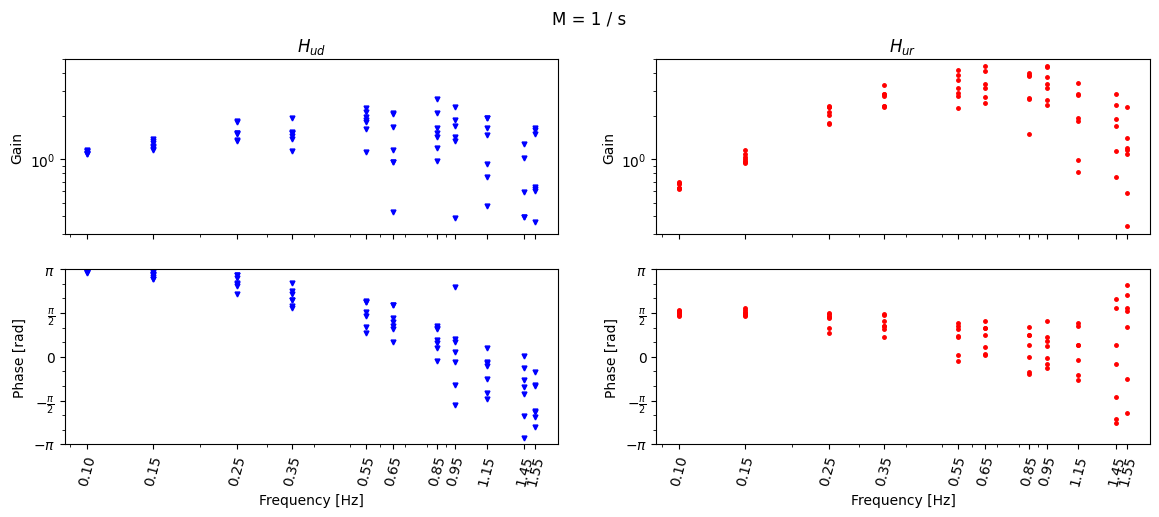

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 5))
dist_fmt = 'bv'
ref_fmt = 'r.'

plt.suptitle("M = 1 / s")
plot_bode(ax[:, 0], Hud_gain[-1][:, FFT_STIM], Hud_phase[1][:, FFT_STIM], r"$H_{ud}$", dist_fmt, markersize=3.5)
plot_bode(ax[:, 1], Hur_gain[-1][:, FFT_STIM], Hur_phase[1][:, FFT_STIM],  r"$H_{ur}$", ref_fmt, markersize=5)

In [ ]:
with CPHS2017Database() as db:
    raw_data = {
        'SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 4, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_ZERO_D_PLUS_ALL': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 10, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_PLUS_ALL_D_ZERO': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 10, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_RAW, NUM_ORDERS,)),
        'SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN': np.empty((NUM_VARIABLES, NUM_PARTICIPANTS, NUM_ORDERS, 2, NUM_SAMPLES_RAW, NUM_ORDERS,)),
    }

    for participant_num in range(7):
        for assay in AssayType:
            for order in range(2):
                expr = f"(participant_num=={participant_num}) & (assay_type=={assay}) & (order == {order + 1})"
                where_list = db.get_where_list(expr)

                raw_data[assay.name][0, participant_num, order, ..., :order] = db.raw_real_time[:][where_list][:, :, np.newaxis] 
                raw_data[assay.name][1, participant_num, order, ..., :order] = db.raw_time[:][where_list][:, :, np.newaxis] 
                raw_data[assay.name][2, participant_num, order, ..., :order] = db.raw_reference[:][where_list][:, :, np.newaxis]  
                raw_data[assay.name][3, participant_num, order, ..., :order] = db.raw_disturbance[:][where_list][:, :, np.newaxis]    
                raw_data[assay.name][4, participant_num, order] = db.raw_state[:][where_list]

In [ ]:
import h5py
from datetime import datetime, timezone
import pandas as pd

PRIMES = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]
EVEN_PRIMES = PRIMES[::2]
ODD_PRIMES = PRIMES[1::2]

with h5py.File("new_data/cphs2017.h5", "w") as f:
    # Add global metadata
    f.attrs["EXPERIMENT_NAME"] = "CPHS2017"
    f.attrs["DESCRIPTION"] = "Sum-of-sines responses with varying reference and disturbance conditions."
    f.attrs["PUBLICATION"] = "doi://10.1016/j.ifacol.2019.01.025"
    f.attrs["AUTHORS"] = ["Yamagami, Momona", "Chow, Ember"]
    f.attrs["EXPERIMENTAL_CONDTION_ID"] = "su17v3"
    f.attrs["DATE_CREATED"] = datetime.now(timezone.utc).isoformat()
    f.attrs["NUM_PARTICIPANTS"] = NUM_PARTICIPANTS
    f.attrs["NUM_ORDERS"] = NUM_ORDERS
    f.attrs["VERSION"] = "1.0"
    f.attrs["SAMPLING_RATE_HZ"] = 60
    f.attrs["SAMPLING_PERIOD_SECS"] = 1 / 60
    f.attrs["SAMPLING_PERIOD_ERR_SECS_95TH_PERCENTILE"] = 15.5e-3
    f.attrs["FIRST_ORDER_MACHINE_TF"] = "1 / s"
    f.attrs["SECOND_ORDER_MACHINE_TF"] = "1 / (s(s + 1))"


    timestamp_grp = f.create_group("timestamps")
    grp = f.create_group("data")
    raw_grp = f.create_group("raw_data")
    fft_grp = f.create_group("fft_data")

    for key in collection_timestamps:
        timestamp_grp.create_dataset(key, data=data[key], compression='gzip', shuffle=True)

    for key in data:
        grp.attrs["DESCRIPTION"] = "The raw data trimmed to the last 2400 samples."
        grp.attrs["NUM_SAMPLES"] = 2400
        grp.create_dataset(key, data=data[key], compression='gzip', shuffle=True)
    
    for key in raw_data:
        grp.attrs["DESCRIPTION"] = "Raw data collected from the experimented used in the original publication."
        raw_grp.attrs["NUM_SAMPLES"] = 2702
        raw_grp.create_dataset(key, data=data[key], compression='gzip', shuffle=True)

    for key in fft_data:
        fft_grp.attrs["DESCRIPTION"] = "The result of scipy.fft.rfft for reference, disturbance, and input (non-raw) data."
        fft_grp.attrs["NUM_SAMPLES"] = 1201
        fft_grp.attrs["BASE_FREQUENCY_HZ"] = 0.05    
        fft_grp.attrs["FIRST_ORDER_SIMULATED_FREQS"] = PRIMES
        fft_grp.attrs["SECOND_ORDER_SIMULATED_FREQS"] = PRIMES[:7]     
        fft_grp.create_dataset(key, data=data[key], compression='gzip', shuffle=True)